## Imports

In [3]:
# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torch.optim.lr_scheduler import StepLR

# Torchvision
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets


# Albumentations for Data Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# PIL for image operations
from PIL import Image

# Matplotlib for plotting and visualizations
import matplotlib.pyplot as plt

# For array operations
import numpy as np

# TensorBoardX - TensorBoard for PyTorch
from tensorboardX import SummaryWriter

# CodeCarbon for tracking our carbon emissions
from codecarbon import EmissionsTracker

import os

## Visualize Dimensions of Images
This this is so we can better understand our data and helps us to decide which fixed image size to choose

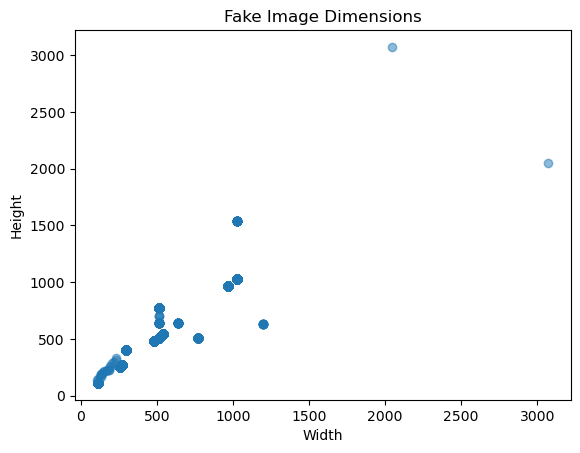

In [4]:
# Plotting dimensions of fake images

image_dir = "/Users/jacob/OneDrive/Desktop/Aletheia/Version2_0/Dataset/Fake/"

# Getting all images in the directory that contains ai-generated faces
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('jpeg', 'jpg', 'png', 'webp'))]

widths = []
heights = []

# Loop through each image and extract its dimensions
for image_file in image_files:
    with Image.open(os.path.join(image_dir, image_file)) as img:
        width, height = img.size
        widths.append(width)
        heights.append(height)

# Plot the dimensions of the images in a scatter plot
plt.scatter(widths, heights, alpha=0.5)
plt.title('Fake Image Dimensions')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

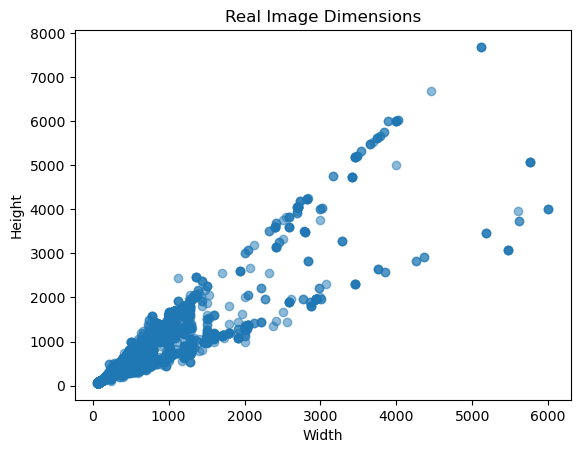

In [5]:
# Plotting dimensions of real images

image_dir = "/Users/jacob/OneDrive/Desktop/Aletheia/Version2_0/Dataset/Real/"

# Getting all images in the directory that contains human faces
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('jpeg', 'jpg', 'png', 'webp'))]

widths = []
heights = []

# Loop through each image and extract its dimensions
for image_file in image_files:
    with Image.open(os.path.join(image_dir, image_file)) as img:
        width, height = img.size
        widths.append(width)
        heights.append(height)

# Plot the dimensions of the images in a scatter plot
plt.scatter(widths, heights, alpha=0.5)
plt.title('Real Image Dimensions')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

## Setup Neural Networks

In [6]:
class CNN(nn.Module):
    """
    A simpler CNN model architecture we used in the beginning.
    This model is fast, but its performance not always optimal.
    """
    def __init__(self, num_classes=2, dropout_prob=0.3):
        super(CNN, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Applying dropout with lower probability for convolutional layers
        self.dropout_conv = nn.Dropout(p=dropout_prob/3)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 64 * 64, 64)

        # Dropout layer for fully connected layers
        self.dropout_fc = nn.Dropout(p=dropout_prob)

        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Convolutional layer 1 with ReLU activation followed by MaxPooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2) 
        x = self.dropout_conv(x)

        # Convolutional layer 2 with ReLU activation followed by MaxPooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout_conv(x)

        # Flatten the output
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)

        return x

In [7]:
class DeeperCNN(nn.Module):
    """
    A deeper CNN that's more complex than the original CNN.
    This model can detect more features but is also slower.
    """
    def __init__(self, dropout_prob=0.3):
        super(DeeperCNN, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # Convolutional layer 1
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_prob * 0.2), # A lower dropout probability for convolutional layers

            # Convolutional layer 2
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_prob * 0.2), # A lower dropout probability for convolutional layers

            # Convolutional layer 3
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_prob * 0.2), # A lower dropout probability for convolutional layers

            # Convolutional layer 4
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_prob * 0.2) # A lower dropout probability for convolutional layers
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(128, 1)  # Final output layer for our binary classification problem
        )

    def feature_size(self):
        """
        Compute the size of flattened features after passing through the convolutional layers.
        This is useful for determining the input size for the fully connected layers.
        """
        return self.conv_layers(torch.zeros(1, 3, 256, 256)).view(1, -1).size(1)

    def forward(self, x):
        # Pass input through convolutional layers
        x = self.conv_layers(x)
        # Flatten tensor
        x = x.view(x.size(0), -1) 
        # Pass flattened tensor through fully connected layers
        x = self.fc_layers(x)
        return x

In [8]:
class ResBlock(nn.Module):
    """
    A residual block that consists of a convolutional block and a skip connection.
    """
    def __init__(self, in_channels, out_channels, dropout_prob=0.2):
        super(ResBlock, self).__init__()
        
        # Define main convolutional block
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob)
        )
        
        # Define skip connection and adapt channels as if needed
        self.residual = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
    
    # Pass input through main block and add skip connection
    def forward(self, x):
        out = self.block(x)
        res = self.residual(x)
        return out + res

class AdjustedResCNN(nn.Module):
    """
    This is an adjust version of our DeeperDNN with slight adjustments the addition of skip connections.
    This is the model architecture of our currently deployed face detection model.
    """
    def __init__(self, dropout_prob=0.3):
        super(AdjustedResCNN, self).__init__()

        # Convolutional layers with residual blocks and max-pooling. The dropout
        self.conv_layers = nn.Sequential(
            ResBlock(3, 24, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(24, 48, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(48, 96, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(96, 192, dropout_prob * 0.2),
            nn.MaxPool2d(2)
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self.feature_size(), 448),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(448, 224),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(224, 112),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(112, 1) # Final layer with one output for our binary classification problem
        )

    def feature_size(self):
        """
        Compute size of flattend features after passing through the convolutional layers.
        This is useful for determining the input size for the fully connected layers
        """
        return self.conv_layers(torch.zeros(1, 3, 256, 256)).view(1, -1).size(1)

    def forward(self, x):
        # Pass input through convolutional layers
        x = self.conv_layers(x)
        # Flatten tensor
        x = x.view(x.size(0), -1) 
        # Pass flattened tensor through fully connected layers
        x = self.fc_layers(x)
        return x

## Set Up Device Agnostic Code

In [9]:
# Set the device to GPU if available, else use the CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Hyperparamters

In [10]:
num_classes = 2
learning_rate = 0.0007
batch_size = 16
num_epochs = 24

## Data
- Load Data
- Split Data
- Apply transformations

In [11]:
class AlbumentationsTransform:
    def __init__(self, transform=None):
        self.transform = transform

    def __call__(self, image):
        if isinstance(image, Image.Image):
            image = np.array(image)
        
        augmented = self.transform(image=image)
        image_tensor = torch.from_numpy(augmented['image'].transpose(2, 0, 1)).float() / 255.0
        return image_tensor

In [12]:
class :
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, image):
        image = self.transform(image)
        return np.array(image)

In [13]:
# Using data augmentation with the albumentations library
torchvision_transform = transforms.Compose([
    transforms.RandomAffine(degrees=2, translate=(0.025, 0.025)), # This helps making the model more robust on mobile (since users usually upload screenshots wich have a different positional format than the actual image), but a high value can weaken the accuracy on desktop (when used in the original image resultion).  
    transforms.Resize((256, 256))  # Resize all images to 256x256
])

torchvision_resize = transforms.Compose(
    transforms.Resize((256, 256))
)

augmentation = A.Compose([
    A.RandomBrightnessContrast(p=0.1),
    A.RandomGamma(p=0.15),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.04, scale_limit=0.04, rotate_limit=6, p=0.3),
    A.GaussNoise(p=0.1),
    A.GaussianBlur(p=0.1),
    A.PixelDropout(dropout_prob=0.013, p=0.35),
])

test_augmentation = A.Compose([
    A.Resize(256, 256)
])

In [14]:
class CustomDataset(Dataset):
    def __init__(self, dataset, torchvision_transforms=None, albumentations_transform=None):
        self.dataset = dataset
        self.torchvision_transforms = torchvision_transforms
        self.albumentations_transform = AlbumentationsTransform(albumentations_transform)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        path, target = self.dataset.dataset.samples[self.dataset.indices[index]]
        image = Image.open(path).convert("RGB")

        # Apply torchvision transforms if defined
        if self.torchvision_transforms:
            image = self.torchvision_transforms(image)
        
        # Apply albumentations transforms if defined
        if self.albumentations_transform:
            image = self.albumentations_transform(image)
        
        return image, target

In [15]:
root_directory = '/Users/jacob/OneDrive/Desktop/Aletheia/Version2_0/Dataset/'

# Load dataset without transformations
full_dataset = datasets.ImageFolder(root=root_directory)

# Set random seed for reproducibility
torch.manual_seed(46)

# Split dataset into train, validation, and test
train_size = int(0.85 * len(full_dataset))  # 85%
validation_size = int(0.05 * len(full_dataset))  # 5%
test_size = len(full_dataset) - train_size - validation_size  # 10%

train_subset, validation_subset, test_subset = random_split(full_dataset, [train_size, validation_size, test_size])

# Apply transformations using the CustomDataset class
train_dataset = CustomDataset(
    train_subset, 
    torchvision_transforms=torchvision_transform, 
    albumentations_transform=augmentation
)

val_dataset = CustomDataset(
    validation_subset, 
    torchvision_transforms=torchvision_transform, 
    albumentations_transform=test_augmentation
)

test_dataset = CustomDataset(
    test_subset, 
    torchvision_transforms=torchvision_transform, 
    albumentations_transform=test_augmentation
)


# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Explore and Visualize Data

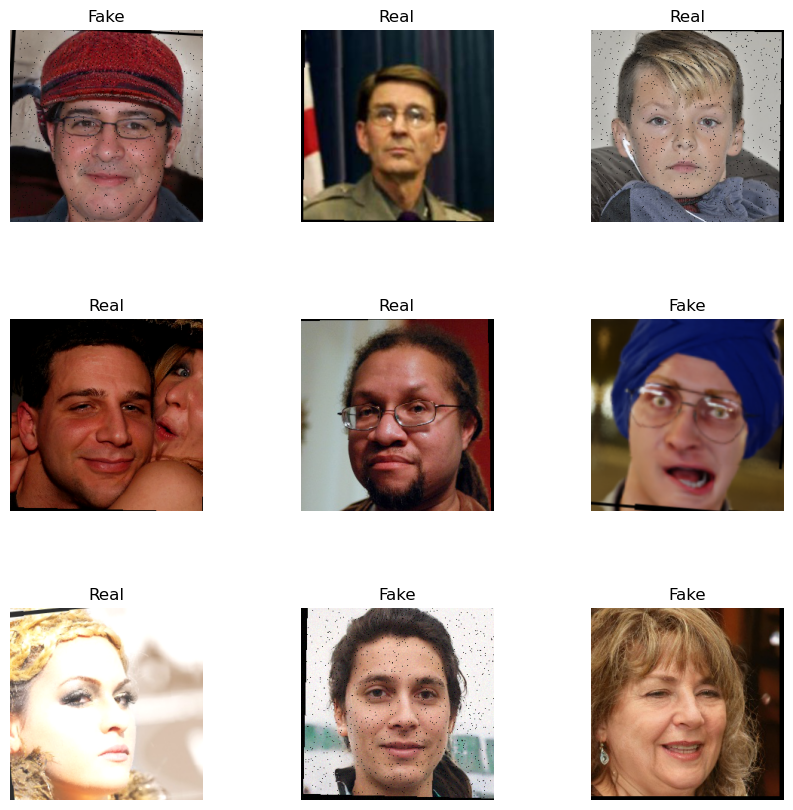

In [16]:
def show_img(dataloader, class_names, num_images=24):
    """Display a batch of images with labels.
    Parameters:
    - dataloader (DataLoader): PyTorch DataLoader containing images and labels.
    - class_names (list): List of class names for labeling.
    - num_images (int, optional): Number of images to display. Default is 10.
    """
    images, labels = next(iter(dataloader))
    
    fig, axes = plt.subplots(3, 3, figsize=(10, 10), 
                             subplot_kw={'xticks':[], 'yticks':[], 'frame_on':False})
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    
    for ax, img, lbl in zip(axes.ravel(), images, labels):  # Here's the change: using axes.ravel()
        img = img.numpy().transpose((1, 2, 0))
        ax.imshow(img)
        ax.set_title(class_names[lbl])
    
    plt.show()

# Using the function to display a few images
show_img(train_loader, class_names=full_dataset.classes)

## Training

### Prepare Training

In [17]:
# Set a fixed random seed for reproducibility
torch.manual_seed(3)

# Initialize the model and transfer it to the GPU (if available)
model = AdjustedResCNN().to(device)

In [18]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.NAdam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=1, gamma=0.94)

In [19]:
writer = SummaryWriter(f'runs/Aletheia2_4')
step = 0

## Define Function for Determining Accuracy of Model

In [20]:
def check_accuracy(loader, model):
    """
    Check the accuracy of the model on a given DataLoader.

    Parameters:
    - loader (DataLoader): DataLoader instance containing the dataset on which accuracy needs to be checked.
    - model (nn.Module): PyTorch model instance which needs to be evaluated.
    """

    print(type(loader))
    num_correct = 0
    num_samples = 0

    # Set the model to evaluation mode.
    model.eval()

    # Ensure no gradients are computed during evaluation
    with torch.inference_mode():
        for x, y in loader:

            # Move the data and labels to the appropriate device
            x = x.to(device=device)
            y = y.to(device=device)

            # Make predictions using the model
            scores = model(x)

            # Convert logits to binary predictions
            predictions = (torch.sigmoid(scores) > 0.5).squeeze(1).long()

            # Accumulate the number of correct predictions and total samples
            num_correct += (predictions == y).sum().item()
            num_samples += predictions.size(0)

        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')

    # Set the model back to training mode
    model.train()

    return num_correct, num_samples

# check_accuracy(train_loader, model)
# check_accuracy(test_loader, model)

## Train Model

In [21]:
carbon_tracker = EmissionsTracker(project_name="Aletheia2_4", log_level="critical")
carbon_tracker.start()

num_correct = 0
num_samples = 0

torch.manual_seed(3)

model = model.to(device)
log_interval = 200

for epoch in range(num_epochs):
    # Resetting accuracy counters at the beginning of each epoch
    num_correct = 0
    num_samples = 0
    
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Move data and targets to the device
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Forward pass
        scores = model(data)
        scores = scores.squeeze(1)
        loss = loss_function(scores.view(-1), targets.float())
        # print(loss.item())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        predictions = (torch.sigmoid(scores) > 0.5).float()
        num_correct += (predictions == targets).sum().item()
        num_samples += predictions.size(0)

        accuracy = 100 * num_correct / num_samples


        # Log the metrics to TensorBoard
        if batch_idx % log_interval == 0:
            writer.add_scalar('Training Loss', loss, epoch * len(train_loader) + batch_idx)
            writer.add_scalar('Training Accuracy', accuracy, epoch * len(train_loader) + batch_idx)
            print("Epoch: ", epoch)
            print(f'Got {num_correct} / {num_samples} with accuracy {accuracy:.2f}')

    print("Epoch: ", epoch)
    print(f'Got {num_correct} / {num_samples} with accuracy {accuracy:.2f}')
    scheduler.step()

    # Check accuracy on the validation loader after each epoch
    print("Checking accuracy on Test Data")
    num_correct_test, num_samples_test = check_accuracy(val_loader, model)
    test_accuracy = 100 * float(num_correct_test) / float(num_samples_test)
    writer.add_scalar('Test Accuracy', test_accuracy, epoch)  # Add test accuracy to TensorBoard

    torch.save(model.state_dict(), f'/Users/jacob/OneDrive/Desktop/Aletheia/Version1_0/state_dicts/al2_4/al2_4model1_epoch_{epoch}_correct{num_correct}.pth')


emissions = carbon_tracker.stop()

# Display Emissions
print(f"Emissions: {emissions:.10f} kgCO2eq")

Epoch:  0
Got 7 / 16 with accuracy 43.75


KeyboardInterrupt: 

## Test state_dict of Trained Model

In [22]:
model = AdjustedResCNN().to(device)

# Create a dummy input and perform a forward pass to dynamically create the fc1 layer
dummy_input = torch.randn(1, 3, 256, 256).to(device)
model(dummy_input)

model_path = '/Users/jacob/OneDrive/Desktop/Aletheia/Version1_0/state_dicts/al2_4/al2_4model1_epoch_19_correct233899.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jacob/OneDrive/Desktop/Aletheia/Version1_0/state_dicts/al2_4/al2_4model1_epoch_19_correct233899.pth'

In [ ]:
check_accuracy(test_loader, model)

<class 'torch.utils.data.dataloader.DataLoader'>
Got 27792 / 28026 with accuracy 99.17


### Test on Specific Generator

In [23]:
class CustomDataset(Dataset):
    def __init__(self, dataset, torchvision_transforms=None, albumentations_transform=None):
        self.dataset = dataset
        self.torchvision_transforms = torchvision_transforms
        self.albumentations_transform = AlbumentationsTransform(albumentations_transform)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        if isinstance(self.dataset, torch.utils.data.Subset):
            path, target = self.dataset.dataset.samples[self.dataset.indices[index]]
        else:
            path, target = self.dataset.samples[index]
        
        image = Image.open(path).convert("RGB")

        # Apply torchvision transforms if defined
        if self.torchvision_transforms:
            image = self.torchvision_transforms(image)
        
        # Apply albumentations transforms if defined
        if self.albumentations_transform:
            image = self.albumentations_transform(image)
        
        return image, target

In [24]:
# Load the new dataset
new_root_directory = "C:\\Users\\jacob\\OneDrive\\Desktop\\real-fake-140k-eval"
new_full_dataset = datasets.ImageFolder(root=new_root_directory)

# Apply data augmentation and images transformations to new dataset
new_test_dataset = CustomDataset(
    new_full_dataset, 
    # torchvision_transforms=torchvision_transform, 
    albumentations_transform=test_augmentation
)

# Create a DataLoader for the new dataset
new_test_loader = DataLoader(new_test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate accuracy on the new dataset
check_accuracy(new_test_loader, model)



<class 'torch.utils.data.dataloader.DataLoader'>
Got 4999 / 5001 with accuracy 99.96


(4999, 5001)

### Try on individual Image

In [25]:
model_path = '/Users/jacob/OneDrive/Desktop/Aletheia/Version1_0/state_dicts/al2_4/al2_4model1_epoch_19_correct233899.pth'
model.load_state_dict(torch.load(model_path))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jacob/OneDrive/Desktop/Aletheia/Version1_0/state_dicts/al2_4/al2_4model1_epoch_19_correct233899.pth'

In [ ]:
model.to(device)

AdjustedResCNN(
  (conv_layers): Sequential(
    (0): ResBlock(
      (block): Sequential(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
        (3): Dropout(p=0.06, inplace=False)
      )
      (residual): Conv2d(3, 24, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ResBlock(
      (block): Sequential(
        (0): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
        (3): Dropout(p=0.06, inplace=False)
      )
      (residual): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1))
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ResB

In [ ]:
def single_image_transforms():
    tv_transform = TorchvisionBridge(torchvision_resize)
    alb_transform = AlbumentationsTransform(test_augmentation)
    
    def combined_transforms(image):
        image = tv_transform(image)
        return alb_transform(image)
    
    return combined_transforms

In [ ]:
def predict_single_image(image_path, model, combined_transforms, device="cuda"):
    """
    Predicts the label for a single image using a pre-trained model.

    Parameters:
    - image_path (str): Path to the image which needs to be predicted.
    - model (nn.Module): Pre-trained PyTorch model instance.
    - combined_transforms: Combined transformations (both torchvision and albumentations) to be applied.
    - device (str): The device where the model and data should be loaded.

    Returns:
    - prediction (float): Predicted probability for the image.
    """
    
    # Load the image
    image = Image.open(image_path).convert("RGB")

    # Apply combined transforms
    image_tensor = combined_transforms(image).unsqueeze(0).to(device)

    # Set the model to evaluation mode and predict
    model.eval()
    with torch.inference_mode():
        scores = model(image_tensor)
        probability = torch.sigmoid(scores).squeeze().item()

    # Set the model back to training mode
    model.train()

    return probability

In [ ]:
image_path = "C:\\Users\\jacob\\OneDrive\\Desktop\\DalleImagesDell\\Untitled design.png"

predicted_label = predict_single_image(
    image_path, 
    model,
    AlbumentationsTransform(test_augmentation)
)

print(f"Predicted label for the image: {predicted_label}")

Predicted label for the image: 0.6550385355949402


In [ ]:
def display_images_from_folder(parent_folder, model, combined_transforms, device="cuda", num_images=80):
    """
    Display images from a parent folder along with their correct label and predicted probability.

    Parameters:
    - parent_folder (str): Path to the parent folder containing class subfolders.
    - model, combined_transforms, device: Parameters to be passed to the predict_single_image function.
    - num_images (int): Number of images to display from each class.

    Returns:
    None
    """
    
    classes = ['real', 'fake']
    all_images = []

    for label in classes:
        class_folder = os.path.join(parent_folder, label)
        image_files = [os.path.join(class_folder, f) for f in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, f))]
        all_images.extend([(img, label) for img in image_files[:num_images]])

    # Two rows and half the total number of images per row
    fig, axs = plt.subplots(8, len(all_images) // 8, figsize=(25, 30))

    for i, (image_path, correct_label) in enumerate(all_images):
        # Get predicted probability
        predicted_probability = predict_single_image(image_path, model, combined_transforms, device=device)
        
        # Load image using PIL
        img = Image.open(image_path)

        # Display image
        row = i // (len(all_images) // 8)  # Determine which row to place the image
        col = i % (len(all_images) // 8)   # Determine which column to place the image
        axs[row, col].imshow(img)
        axs[row, col].set_title(f"Correct: {correct_label}\nPred: {predicted_probability:.4f}")
        axs[row, col].axis("off")
    
    plt.tight_layout()
    plt.show()




IndexError: index 8 is out of bounds for axis 0 with size 8

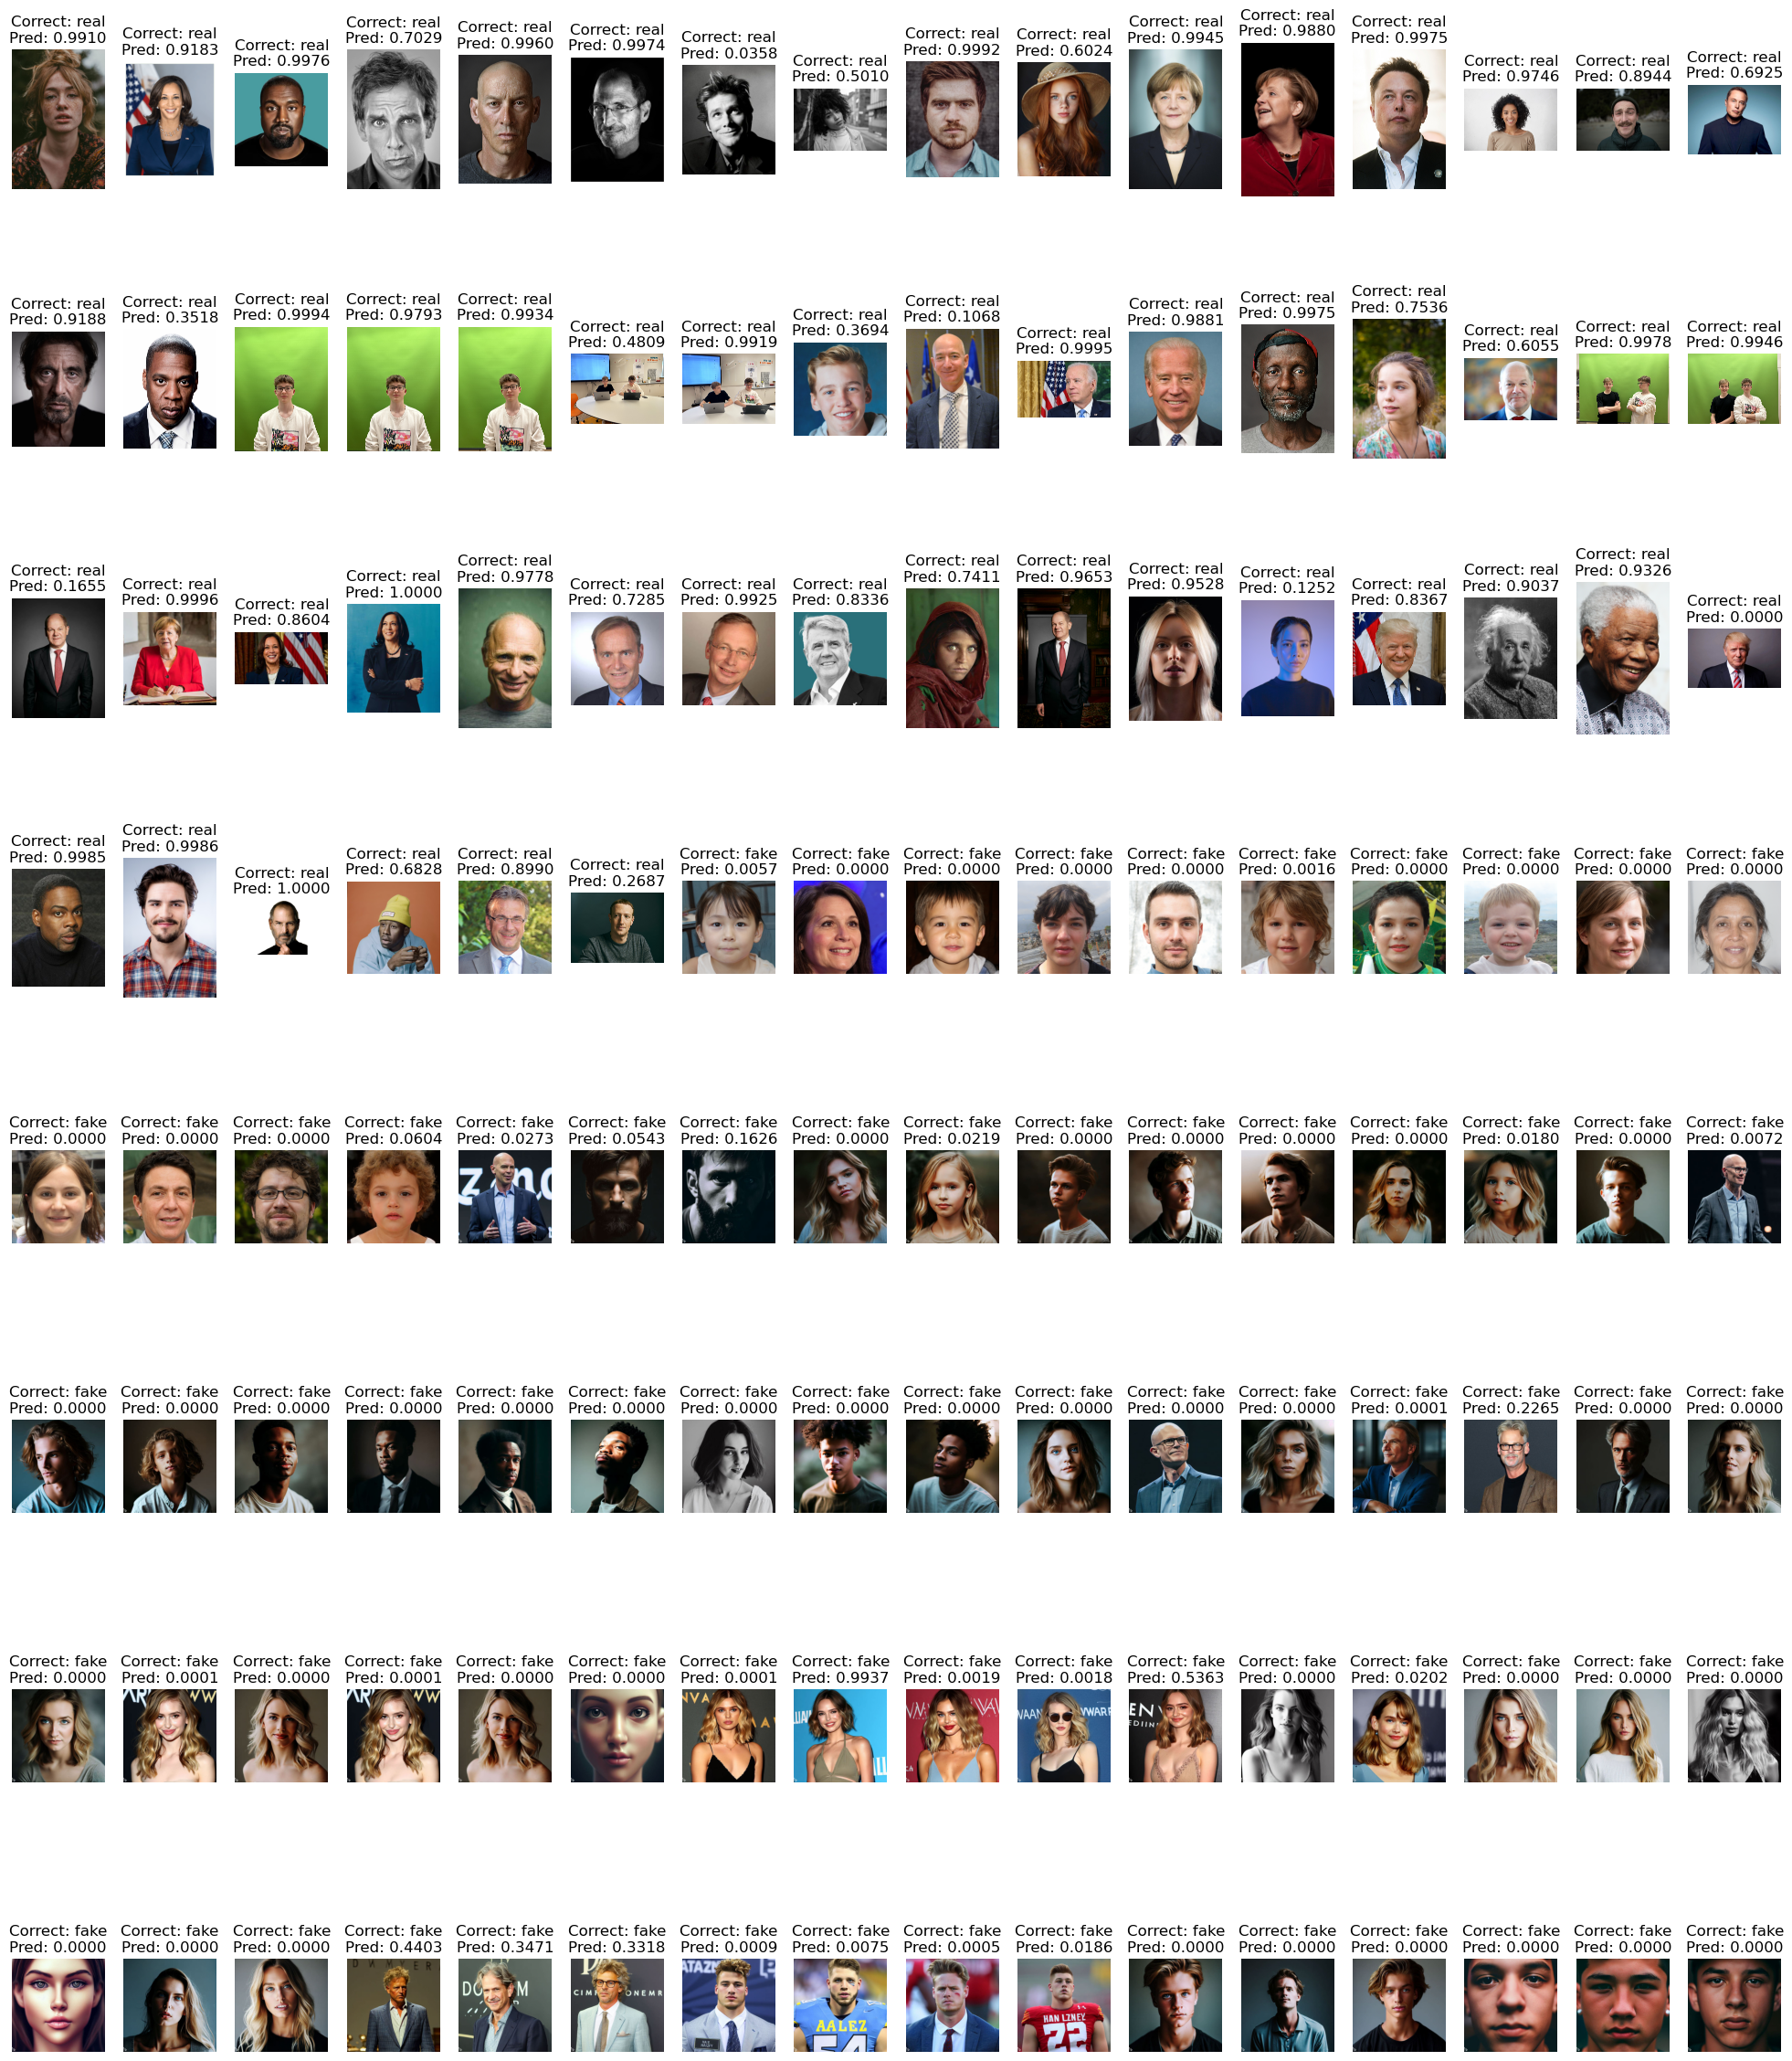

In [ ]:
combined_transforms = single_image_transforms()  # Get the combined transforms
display_images_from_folder("/Users/jacob/OneDrive/EvalProperties", model, combined_transforms)